In [17]:
# Problem : 2 class Linear classifier (Diabetes or not)
# Dataset : Diabetes.csv
# Methods : a) Gradient Descent

In [18]:
!gdown "1CDZGvTWA_7dLgEW_lv3Rm_5flw7FjmPW&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1CDZGvTWA_7dLgEW_lv3Rm_5flw7FjmPW&confirm=t
To: /content/Diabetes.csv
100% 23.9k/23.9k [00:00<00:00, 28.0MB/s]


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Load the diabetes dataset.csv file into a pandas DataFrame
Diabetes_df = pd.read_csv('/content/Diabetes.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Diabetes_df.drop('Outcome', axis=1),
                                                    Diabetes_df['Outcome'],
                                                    test_size=0.2, random_state=42)
#We get these optimal values when we run graident descent algorthim for so many iterations
optimum_weights = np.array([[-0.74912864 ,0.16994032 ,0.60079793,-0.06258882,0.01357402,-0.01708432,0.4208918,0.15230881,0.28123772]])
optimum_loss = 0.5253827

In [21]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add bias term to the input data
X_train_scaled = np.insert(X_train_scaled, 0, 1, axis=1)
X_test_scaled = np.insert(X_test_scaled, 0, 1, axis=1)


# print(f"X train scaled shape:{X_test_scaled.shape}")
# print(f"X train scaled shape:{y_test.shape}")
# print(X_train_scaled)

In [22]:
class LinearClassifier_GD:
    def __init__(self, epsilon=1e-7, reg_strength=0.01, learning_rate=0.01, max_iterations=1000):
        self.reg_strength = reg_strength
        self.learning_rate = learning_rate
        self.num_iterations = max_iterations
        self.epsilon = epsilon
        
    def fit(self, X, y):
        weights_history = []
     
        # # Initialize weights
        self.weights = np.zeros(X.shape[1])
        
        # Randomly initialize weights
        #self.weights = np.random.rand(X.shape[1])


        # Gradient descent
        for i in range(self.num_iterations):

            # prev weights
            prev_weights = self.weights.copy()

            # Compute predictions            
            y_pred = self.predict_proba(X)
            
            # Compute loss and regularization term
            loss = (-1/X.shape[0]) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            reg_term = (self.reg_strength/2) * np.sum(self.weights[1:]**2)
            total_loss = loss + reg_term
            weights_history.append(self.weights.copy())
            
            # Compute gradients
            gradient = (1/X.shape[0]) * np.dot(X.T, y_pred - y)
            reg_gradient = np.append(0, self.reg_strength * self.weights[1:])
            total_gradient = gradient + reg_gradient
            
            # Update weights
            self.weights -= self.learning_rate * total_gradient
            error_weights = self.weights - optimum_weights
            #Check stopping criterion
            if i > 0 and np.abs(total_loss - optimum_loss) < self.epsilon:
                print(f"stopped at iteration number:{i}")
                print(f"R^2 : {np.linalg.norm(self.weights)**2}")
                print(f"iteration number:{i} loss:{total_loss}")
                break
            prev_loss = total_loss
        errors=[]
        for i in weights_history:
          i=np.array(i)
          errors.append(np.linalg.norm(i-optimum_weights))
        return errors

    
    def predict_proba(self, X):
        # Compute predictions
        logits = np.dot(X, self.weights)
        return 1 / (1 + np.exp(-logits))
    
    def predict(self, X, threshold=0.5):
        # Predict binary labels using a threshold
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)


epsilon accuracy :0.0001
max eval X_train :71.60011262344504
L:18.10002815586126
step size : 0.05524853284143506
stopped at iteration number:326
R^2 : 1.1688305489447772
iteration number:326 loss:0.5254811918220887


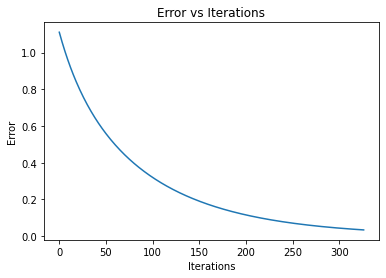

In [23]:
#  regularization strength
reg_strength = 0.1

# epsilon accuracy
epsilon = 1e-4
print(f"epsilon accuracy :{epsilon}")
# max eval calculation to find step size
def calculate_max_Eval(X):
    return np.max(np.sum(X**2, axis=1))

def calculate_step_size():
    eval=calculate_max_Eval(X_train_scaled)
    print(f"max eval X_train :{eval}")
    L = (2*reg_strength + (eval/4))
    print(f"L:{L}")
    step_size = 1/L 
    print(f"step size : {step_size}")
    return step_size


# Initialize the linear classifier
# classifier = LinearClassifier_GD(reg_strength, learning_rate= calculate_step_size(), max_iterations=1000, epsilon=1e-3)
classifier = LinearClassifier_GD(epsilon, reg_strength, learning_rate= calculate_step_size(), max_iterations=10000)

# Fit the linear classifier to the training data
Error_hist_1=classifier.fit(X_train_scaled, y_train)

# Plot the loss vs iterations
plt.plot(range(len(Error_hist_1)), Error_hist_1)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error vs Iterations')
plt.show()

In [24]:
# Compute the predictions on the testing set
# print(X_test.shape)
y_pred_test = classifier.predict(X_test_scaled)

# Compute the accuracy on the testing set
accuracy = np.mean(y_pred_test == y_test)
print(f'Testing accuracy: {accuracy:.4f}')


Testing accuracy: 0.7857


### **P2**

In [25]:
class LinearClassifier_Heavy_Ball_GD:
    def __init__(self, epsilon=1e-7, reg_strength=0.01, learning_rate=0.01, max_iterations=1000, momentum=0.95):
        self.reg_strength = reg_strength
        self.learning_rate = learning_rate
        self.num_iterations = max_iterations
        self.epsilon = epsilon
        self.momentum = momentum
        
    def fit(self, X, y):
        weights_history = []
     
        # # Initialize weights
        self.weights = np.zeros(X.shape[1])
        self.update_weights = np.zeros(X.shape[1])
        # Randomly initialize weights
        #self.weights = np.random.rand(X.shape[1])


        # Gradient descent
        for i in range(self.num_iterations):
            # Compute predictions
            y_pred = self.predict_proba(X)
            # print("no error")
            # Compute loss and regularization term
            loss = (-1/X.shape[0]) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            reg_term = (self.reg_strength/2) * np.sum(self.weights[1:]**2)
            total_loss = loss + reg_term
            weights_history.append(self.weights.copy())
            # print(self.weights)
            # print(loss_history[i])

            # Compute gradients
            gradient = (1/X.shape[0]) * np.dot(X.T, y_pred - y)
            reg_gradient = np.append(0, self.reg_strength * self.weights[1:])
            total_gradient = gradient + reg_gradient
            
            # Update weights
            self.update_weights = self.momentum*self.update_weights + self.learning_rate * total_gradient
            self.weights = self.weights - self.update_weights
            
            # Check stopping criterion
            if i > 0 and np.abs(total_loss - optimum_loss) < self.epsilon:
                print(f"stopped at iteration number:{i}")
                print(f"iteration number:{i} loss:{total_loss}")
                print(f"R^2 : {np.linalg.norm(self.weights)**2}")
                print(f"momentum : {self.momentum}")
                print(f"step size : {self.learning_rate}")  
                break

            if i%10==0:
              # print(f"iteration number:{i} loss:{total_loss}")
              pass
            prev_loss = total_loss
        optim_weight = self.weights.copy()
        print(np.linalg.norm(optim_weight))
        errors=[]
        for i in weights_history:
          i=np.array(i)
          optim_weight = np.array(optim_weight)
          errors.append(np.linalg.norm(i-optim_weight))
        return errors

    
    def predict_proba(self, X):
        # Compute predictions
        logits = np.dot(X, self.weights)
        return 1 / (1 + np.exp(-logits))
    
    def predict(self, X, threshold=0.5):
        # Predict binary labels using a threshold
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)


In [26]:
#regularization strength
reg_strength = 0.1

#stopping criteria accuracy value

print(f"epsilon accuracy:{epsilon}")

# max eval calculation to find step size
def calculate_max_Eval(X):
    return np.max(np.sum(X**2, axis=1))

def calculate_L():
  eval=calculate_max_Eval(X_train_scaled)
  return 2*reg_strength + (eval/4)
  
def calculate_step_size():
    eval=calculate_max_Eval(X_train_scaled)
    print(f"max eval:{eval}")
    L = 2*reg_strength + (eval/4)
    #L = reg_strength + (eval)
    print(f"L:{L}")
    print(f"step size : {1/L}")
    return (1/L)

def calculate_beta_size():
  alpha = 0.02
  mu = reg_strength
  x1 = mu*alpha/2
  x2 = ((mu*alpha)**2 / 4)
  x3  = 4*(1-(alpha*calculate_L())/2)
  return 0.5*(x1 + (x2+x3)**0.5)

beta = calculate_beta_size()
print(f"beta :{beta}")

def calculate_step_size2():
  mu = reg_strength
  L = 1/calculate_step_size()
  return 2/(mu+L)

# Initialize the linear classifier
# classifier = LinearClassifier_GD(reg_strength, learning_rate= calculate_step_size(), max_iterations=1000, epsilon=1e-3)
classifier = LinearClassifier_Heavy_Ball_GD(epsilon, reg_strength, learning_rate= 0.02, max_iterations=1000,  momentum=0.9)

# Fit the linear classifier to the training data
Error_hist_2=classifier.fit(X_train_scaled, y_train)
# # Plot the loss vs iterations
# plt.plot(range(len(Error_hist)), Error_hist)
# plt.xlabel('Iterations')
# plt.ylabel('Error')
# plt.title('Error vs Iterations')
# plt.show()

epsilon accuracy:0.0001
beta :0.9054861703039375
stopped at iteration number:58
iteration number:58 loss:0.5254756957097618
R^2 : 1.2097698683020814
momentum : 0.9
step size : 0.02
1.099895389708531


In [27]:
#This algorthim is we additionally mention in Presentation to converge faster than Normal NAGD
class LinearClassifier_Simple_NAGD:
    def __init__(self, reg_strength=0.01, learning_rate=0.01, max_iterations=1000, epsilon=1e-7 , momentum=0.9):
        self.reg_strength = reg_strength
        self.learning_rate = learning_rate
        self.num_iterations = max_iterations
        self.epsilon = epsilon
        self.momentum = momentum
        
    def fit(self, X, y):
        loss_history = []
     
        # # Initialize weights
        self.weights = np.zeros(X.shape[1])
        self.weights_lahead = np.zeros(X.shape[1])
        
        # Randomly initialize weights
        #self.weights = np.random.rand(X.shape[1])


        # Gradient descent
        update_w=0
        for i in range(self.num_iterations):
            # Compute predictions
            y_pred = self.predict_proba(X)
            # print("no error")
            # Compute loss and regularization term
            loss = (-1/X.shape[0]) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            reg_term = (self.reg_strength/2) * np.sum(self.weights[1:]**2)
            total_loss = loss + reg_term
            loss_history.append(self.weights.copy())
            # print(self.weights)
            # print(loss_history[i])

            # Compute gradients
            self.weights_lahead = self.weights - self.momentum*update_w
            y_pred_lhead = self.predict_proba_lahead(X)
            gradient = (1/X.shape[0]) * np.dot(X.T, y_pred_lhead - y)
            reg_gradient = np.append(0, self.reg_strength * self.weights_lahead[1:])
            total_gradient = gradient + reg_gradient
            
            # Update weights
            update_w = self.momentum*update_w + self.learning_rate * total_gradient
            self.weights = self.weights - update_w
            
            # Check stopping criterion
            if i > 0 and np.abs(total_loss - optimum_loss) < self.epsilon:
                print(f"stopped at iteration number:{i}  Loss is : {total_loss}")
                print(f"R^2 : {np.linalg.norm(self.weights_lahead)**2}")  
                break

            if i%10==0:
              # print(f"iteration number:{i} loss:{total_loss}")
              pass
            prev_loss = total_loss
        exact_weight = self.weights
        errors=[]
        for i in loss_history:
          i=np.array(i)
          exact_weight = np.array(exact_weight)
          errors.append(np.linalg.norm(i-optimum_weights))
        return errors

    
    def predict_proba(self, X):
        # Compute predictions
        logits = np.dot(X, self.weights)
        return 1 / (1 + np.exp(-logits))
    
    def predict_proba_lahead(self, X):
        # Compute predictions
        logits = np.dot(X, self.weights_lahead)
        return 1 / (1 + np.exp(-logits))
    
    def predict(self, X, threshold=0.5):
        # Predict binary labels using a threshold
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)


Epsilon : 0.0001
L:18.10002815586126
step size : 0.05524853284143506
stopped at iteration number:54  Loss is : 0.5254733815231432
R^2 : 1.174941918993948


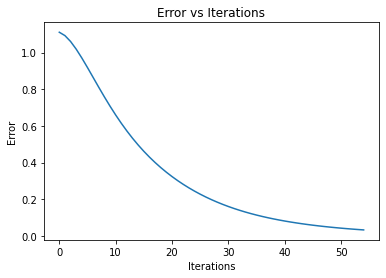

In [28]:
reg_strength = 0.1

print(f"Epsilon : {epsilon}")
# max eval calculation to find step size
# def calculate_max_Eval(X):
#     return np.max(np.sum(X**2, axis=1))

def calculate_L():
  eval=calculate_max_Eval(X_train_scaled)
  return 2*reg_strength + eval/4

def calculate_step_size():
    L = calculate_L()
    print(f"L:{L}")
    print(f"step size : {1/L}")
    return (1/L)

def calculate_momentum():
  L=calculate_L()
  mu= reg_strength
  print(f"Momentum : {(L**0.5 - mu**0.5)/(L**0.5 + mu**0.5)}")
  return (L**0.5 - mu**0.5)/(L**0.5 + mu**0.5)

# Initialize the linear classifier
# classifier = LinearClassifier_GD(reg_strength, learning_rate= calculate_step_size(), max_iterations=1000, epsilon=1e-3)
classifier = LinearClassifier_Simple_NAGD(reg_strength, learning_rate= calculate_step_size(), max_iterations=1000, epsilon=epsilon, momentum=0.8)

# Fit the linear classifier to the training data
Error_hist=classifier.fit(X_train_scaled, y_train)
# Plot the loss vs iterations
plt.plot(range(len(Error_hist)), Error_hist)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error vs Iterations')
plt.show()

In [29]:
class LinearClassifier_Nestrov_GD:
    def __init__(self, epsilon=1e-7, reg_strength=0.1, learning_rate=0.01, max_iterations=1000):
        self.reg_strength = reg_strength
        self.learning_rate = learning_rate
        self.num_iterations = max_iterations
        self.epsilon = epsilon
        
    def fit(self, X, y):
        loss_history = []
     
        # # Initialize weights
        self.weights = np.zeros(X.shape[1])
        self.weightsy = np.zeros(X.shape[1])
        self.weightsz = np.zeros(X.shape[1])
        
        # Randomly initialize weights
        #self.weights = np.random.rand(X.shape[1])


        # Gradient descent
        update_w=0
        for i in range(self.num_iterations):
            # Compute predictions
            y_pred = self.predict_proba(X)
            # print("no error")
            # Compute loss and regularization term
            loss = (-1/X.shape[0]) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            reg_term = (self.reg_strength/2) * np.sum(self.weights[1:]**2)
            total_loss = loss + reg_term
            loss_history.append(self.weights.copy())
            # print(self.weights)
            # print(loss_history[i])

            # Compute gradients
            gradient = (1/X.shape[0]) * np.dot(X.T, y_pred - y)
            reg_gradient = np.append(0, self.reg_strength * self.weights[1:])
            total_gradient = gradient + reg_gradient
            
            # Update weights
            self.weightsy = self.weights - self.learning_rate * total_gradient
            self.weightsz = self.weightsz - self.learning_rate*(i+1)/2 * total_gradient
            self.weights = (i+1)/(i+3) * self.weightsy + 2/(i+3) * self.weightsz
            
            # Check stopping criterion
            if i > 0 and np.abs(total_loss - optimum_loss) < self.epsilon:
                print(f"stopped at iteration number:{i} Loss is  {total_loss}")
                print(f"R^2 : {np.linalg.norm(self.weights)**2}")  
                break

            prev_loss = total_loss
        exact_weight = self.weights
        errors=[]
        for i in loss_history:
          i=np.array(i)
          exact_weight = np.array(exact_weight)
          errors.append(np.linalg.norm(i-optimum_weights))
        return errors

    
    def predict_proba(self, X):
        # Compute predictions
        logits = np.dot(X, self.weights)
        return 1 / (1 + np.exp(-logits))
    
    def predict(self, X, threshold=0.5):
        # Predict binary labels using a threshold
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)


epsilon accuracy : 0.0001
stopped at iteration number:15 Loss is  0.5254771092481344
R^2 : 1.2856984494842274


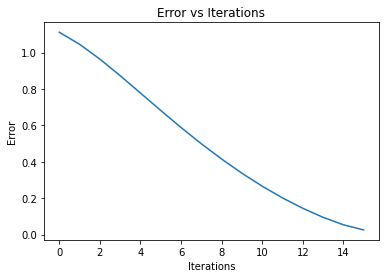

In [30]:

print(f"epsilon accuracy : {epsilon}")
reg_strength = 0.1
# max eval calculation to find step size
def calculate_max_Eval(X):
    return np.max(np.sum(X**2, axis=1))

def calculate_L():
  eval=calculate_max_Eval(X_train_scaled)
  return 2*reg_strength + (eval/4)

def calculate_step_size():
    eval=calculate_max_Eval(X_train_scaled)
    print(f"max eval:{eval}")
    L = 2*reg_strength + (eval/4)
    #L = reg_strength + (eval)
    print(f"L:{L}")
    print(f"step size : {1/L}")
    return (1/L)


# Initialize the linear classifier
classifier = LinearClassifier_Nestrov_GD(epsilon, reg_strength, learning_rate= 0.3, max_iterations=1000)

# Fit the linear classifier to the training data
Error_hist_3=classifier.fit(X_train_scaled, y_train)
# Plot the loss vs iterations
plt.plot(range(len(Error_hist_3)), Error_hist_3)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error vs Iterations')
plt.show()

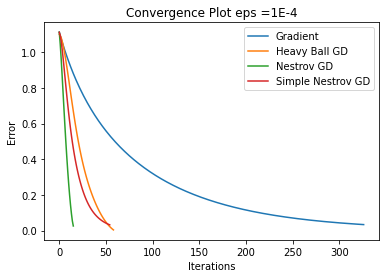

In [31]:
plt.plot(range(len(Error_hist_1)), Error_hist_1 , label="Gradient")
plt.plot(range(len(Error_hist_2)), Error_hist_2 , label = "Heavy Ball GD")
plt.plot(range(len(Error_hist_3)), Error_hist_3, label = "Nestrov GD")
plt.plot(range(len(Error_hist)), Error_hist, label = "Simple Nestrov GD")
plt.title('Convergence Plot eps =1E-4')
plt.xlabel('Iterations')
plt.legend()
plt.ylabel('Error')
plt.show()